In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input, GetImgAndTextEmbs

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

import pandas as pd

In [3]:
OUT_DIM=2
INPUT_DIM=128
BS= 8
torch.cuda.set_device(1)

In [4]:
from fastai import __version__
print('fastai: ',__version__)
print(' torch: ',torch.__version__)

fastai:  2.1.3
 torch:  1.7.0+cu110


In [5]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [6]:
train.shape

(819, 5)

In [7]:
import re
def add_page(row):
    docid = row['docid']
    match = re.match(r"^[\w\-]+\_(\d+)", docid)
    if match: #and match[1] is not None:
        row['page'] = int(match[1])
    else:
        row['page'] = 1
    return row    

def add_doc_radical(row):
    docid = row['docid']
    match = re.match(r"^([a-zA-Z\d\-]+)(\_\d+)*", docid)
    if match: #and match[1] is not None:
        row['doc_radical'] = match[1]
    else:
        row['doc_radical'] = 'UNK'
    return row   

def add_pages(row):
    doc_radical = row['doc_radical']
    if match: #and match[1] is not None:
        row['page'] = int(match[1])
    else:
        row['page'] = 1
    return row      
def prepare_df(df):
    df = df.apply(add_page, axis=1)
    df = df.apply(add_doc_radical, axis=1)
    df['pages'] = df.groupby('doc_radical')['page'].transform('max')
    return df

In [8]:
#train

In [9]:
train = prepare_df(train)
val = prepare_df(val)
test_data = prepare_df(test_data)

In [9]:
# train["document_type"] = train.apply(lambda x: "B-" + x["class"] if x["page"] == 1 else "I-" + x["class"],
#                                      axis=1)
# val["document_type"] = val.apply(lambda x: "B-" + x["class"] if x["page"] == 1 else "I-" + x["class"],
#                                      axis=1)
# test_data["document_type"] = test_data.apply(lambda x: "B-" + x["class"] if x["page"] == 1 else "I-" + x["class"],
#                                    axis=1)

In [10]:
X_train, y_train = get_sequences(train, 50)
X_valid, y_valid = get_sequences(val, 50)
X_test, y_test = get_sequences(test_data, 50)

In [11]:
X_train[0][:5], y_train[0][:5]

(['activations/text/train/FirstPage/aah97e00-page02_1',
  'activations/text/train/NextPage/aah97e00-page02_2',
  'activations/text/train/FirstPage/aam09c00',
  'activations/text/train/FirstPage/aao54e00_1',
  'activations/text/train/NextPage/aao54e00_2'],
 ['FirstPage', 'NextPage', 'FirstPage', 'FirstPage', 'NextPage'])

In [12]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": [False for _ in range(len(X_train))]}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": [True for _ in range(len(X_valid))]})])

In [13]:
_min = 100
_min_ix = -1
for index, row in data.iterrows():
    if _min > len(row['acts']):
        _min = len(row['acts'])
        _min_ix = index
print(_min, _min_ix)

21 2


In [14]:
len(data.iloc[14,0])

48

In [15]:
#data

In [16]:
my_pad_input=My_Pad_Input(2)

In [17]:
tfms = [[GetImgAndTextEmbs()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1]), bs=BS)

In [18]:
dls.one_batch()

(TensorImage([[[0.5401, 1.4210, 1.5567,  ..., 0.0000, 0.0852, 0.0000],
          [0.3286, 0.6557, 1.1641,  ..., 0.0000, 0.0852, 0.0000],
          [0.7914, 1.7443, 2.2198,  ..., 0.0541, 0.0855, 0.1106],
          ...,
          [1.5196, 1.8884, 0.6367,  ..., 0.0000, 0.0852, 0.0000],
          [0.1261, 0.3667, 0.9103,  ..., 0.0000, 0.0852, 0.0000],
          [1.6152, 1.6663, 0.4535,  ..., 0.0000, 0.0852, 0.0000]],
 
         [[0.3202, 1.2138, 0.3604,  ..., 0.0000, 0.0852, 0.0000],
          [0.3590, 0.5312, 0.9131,  ..., 0.0454, 0.0798, 0.0450],
          [0.6861, 0.7871, 1.7014,  ..., 0.0000, 0.0852, 0.0000],
          ...,
          [1.3441, 2.1549, 0.9034,  ..., 0.0000, 0.0852, 0.0000],
          [4.2857, 1.6863, 1.9135,  ..., 0.0000, 0.0852, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.5581, 0.5553, 0.8438,  ..., 0.0000, 0.0852, 0.0000],
          [0.7305, 0.7456, 1.0972,  ..., 0.0000, 0.0852, 0.0000],
          [0.1802, 0.2729, 1.1638, 

In [19]:
torch.save(dls, "./data/dls_sequence_from_embs.pth")

In [20]:
dls = torch.load("./data/dls_sequence_from_embs.pth")

In [21]:
# dls.one_batch()

In [41]:
class LSTMModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=256):
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4).cuda()
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU().cuda()
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [42]:
model = LSTMModel(7936, OUT_DIM, hidden_dim=256)

In [24]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [25]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([OUT_DIM])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [26]:
dls.bs = dls.train.bs = dls.valid.bs = 8

In [27]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [28]:
learn.summary()

LSTMModel (Input shape: ['8 x 50 x 7936'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['8 x 50 x 512', "[  2,625,536  True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 50        15,872     True      
________________________________________________________________
BatchNorm1d          8 x 512 x 50         1,024      True      
________________________________________________________________
Dropout              8 x 7936 x 50        0          False     
________________________________________________________________
Dropout              8 x 512 x 50         0          False     
________________________________________________________________
Linear               8 x 50 x 1024        8,127,488  True      
________________________________________________________________
Linear               8 x 50 x 2           1,026      True      
_______________________________________________________

In [29]:
learn.validate()

(#2) [0.6982851624488831,0.34532374100719426]

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=7.585775892948732e-05)

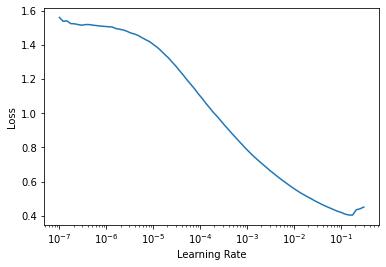

In [33]:
learn.lr_find()

In [30]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs256_morepochs_tobacco'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.631864,0.660967,0.380049,00:02
1,0.436935,0.652091,0.519171,00:01
2,0.329009,0.631270,0.610253,00:01
3,0.255571,0.645902,0.519171,00:01
4,0.206731,0.641207,0.519171,00:01
5,0.171709,0.663759,0.519171,00:02
6,0.147151,0.644458,0.519171,00:02
7,0.127190,0.643263,0.519171,00:02
8,0.112143,0.623929,0.543096,00:01
9,0.099424,0.618069,0.550887,00:01


Better model found at epoch 0 with f1_score value: 0.3800486618004866.


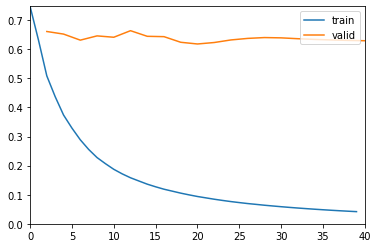

Better model found at epoch 1 with f1_score value: 0.5191708440590705.
Better model found at epoch 2 with f1_score value: 0.6102530824140169.


In [31]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [32]:
learn.load("best_sequence_from_embs256_morepochs_tobacco")

In [35]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([OUT_DIM])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))

In [34]:
dls.get_labels.cat.vocab

['FirstPage', 'NextPage']

In [36]:
evaluate(learn, dls.valid)

              precision    recall  f1-score   support

   FirstPage     0.5694    0.9535    0.7130        86
    NextPage     0.8947    0.3542    0.5075        96

    accuracy                         0.6374       182
   macro avg     0.7321    0.6538    0.6103       182
weighted avg     0.7410    0.6374    0.6046       182



In [37]:
test_data = pd.DataFrame({"acts":X_test, "labels":y_test})

In [38]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [39]:
torch.save(test_dl, "./data/test_dl_sequence_from_embs.pth")

In [40]:
evaluate(learn, test_dl)

              precision    recall  f1-score   support

   FirstPage     0.6429    0.9854    0.7781       137
    NextPage     0.9310    0.2647    0.4122       102

    accuracy                         0.6778       239
   macro avg     0.7869    0.6251    0.5952       239
weighted avg     0.7658    0.6778    0.6219       239

